In [1]:
import pandas as pd
from os.path import join
from sklearn.utils import shuffle

emotions = ["happy", "sad", ["disgust", "disgust2"], "angry", "fear", "surprise", "neutral"]
dir_path = "gathering/ja_tweets_sentiment"
size = 40000
df = []
for i, es in enumerate(emotions):
    if isinstance(es, list):
        for e in es:
            data = shuffle(pd.read_json(join(dir_path, "{}.json".format(e)))).iloc[:int(size/len(es))]
            data['label'] = i
            df.append(data)
    else:
        data = shuffle(pd.read_json(join(dir_path, "{}.json".format(es)))).iloc[:int(size)]
        data['label'] = i
        df.append(data)

df = pd.concat(df)
df.shape

(280000, 11)

In [2]:
df = shuffle(df)

In [3]:
X = df['text']
y = df['label']

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

max_features=10000
maxlen = 280

y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

tokenizer = Tokenizer(num_words=max_features, filters="", char_level=True)
tokenizer.fit_on_texts(list(X_train))

def preprocess(data, tokenizer, maxlen=280):
    return(pad_sequences(tokenizer.texts_to_sequences(data), maxlen=maxlen))

X_train = preprocess(X_train, tokenizer)
X_test = preprocess(X_test, tokenizer)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((157500, 280), (52500, 280), (70000, 280))

In [7]:
import pickle

with open("tokenizer_cnn_ja.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [8]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

In [12]:
model = Sequential()
model.add(Embedding(max_features, 150, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(7, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
epochs = 15
batch_size = 1000

In [13]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

Train on 157500 samples, validate on 52500 samples
Epoch 1/15
157500/157500 [==============================] - 10s 61us/step - loss: 1.7913 - acc: 0.2633 - val_loss: 1.7203 - val_acc: 0.3066
Epoch 2/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.6866 - acc: 0.3250 - val_loss: 1.6538 - val_acc: 0.3498
Epoch 3/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.6223 - acc: 0.3682 - val_loss: 1.6303 - val_acc: 0.3729
Epoch 4/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.5741 - acc: 0.3976 - val_loss: 1.5868 - val_acc: 0.3932
Epoch 5/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.5415 - acc: 0.4161 - val_loss: 1.5629 - val_acc: 0.4072
Epoch 6/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.5151 - acc: 0.4295 - val_loss: 1.5707 - val_acc: 0.4034
Epoch 7/15
157500/157500 [==============================] - 6s 39us/step - loss: 1.4914 - acc: 0.4405 - val_loss: 

In [14]:
import numpy as np
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

In [15]:
emolabels = []
for e in emotions:
    if isinstance(e, list):
        emolabels.append(e[0])
    else:
        emolabels.append(e)

In [16]:
from sklearn.metrics import classification_report

In [17]:
print(classification_report(y_true, y_preds, target_names=emolabels))

             precision    recall  f1-score   support

      happy       0.56      0.47      0.51     10117
        sad       0.65      0.45      0.53      9892
    disgust       0.31      0.52      0.39     10115
      angry       0.41      0.46      0.43      9806
       fear       0.43      0.48      0.45      9945
   surprise       0.45      0.38      0.41      9981
    neutral       0.30      0.20      0.24     10144

avg / total       0.44      0.42      0.42     70000



In [18]:
model.save("model_2018-08-28-15:00.h5")

In [18]:
from keras.models import load_model
import pickle
model = load_model("models/ja_tweets_sentiment/model_2018-08-28-15:00.h5")

with open("models/ja_tweets_sentiment/tokenizer_cnn_ja.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [19]:
def preprocess(data, tokenizer, maxlen=280):
    return(pad_sequences(tokenizer.texts_to_sequences(data), maxlen=maxlen))

In [40]:
examples = [
    "まじきもい、あいつ",
    "今日は楽しい一日だったよ",
    "ペットが死んだ、実に悲しい",
    "ふざけるな、死ね",
    "ストーカー怖い",
    "すごい！ほんとに！？",
    "葉は植物の構成要素です。",
    "ホームレスと囚人を集めて革命を起こしたい",
    "数学は科学に用いられます。",
    "りんごは赤い。",
    "とうもろこしは食べ物です。"
]

targets = preprocess(examples, tokenizer, maxlen=maxlen)
print('\t'.join(emolabels))
for i, ds in enumerate(model.predict(targets)):
    print('\t'.join([str(round(100.0*d)) for d in ds]))

happy	sad	disgust	angry	fear	surprise	neutral
3.0	4.0	14.0	9.0	6.0	3.0	8.0
11.0	2.0	4.0	4.0	3.0	3.0	5.0
0.0	11.0	7.0	2.0	6.0	1.0	2.0
1.0	3.0	20.0	15.0	4.0	2.0	8.0
1.0	2.0	15.0	3.0	25.0	3.0	6.0
1.0	2.0	3.0	2.0	3.0	13.0	3.0
8.0	0.0	1.0	0.0	1.0	8.0	1.0
1.0	1.0	7.0	30.0	3.0	2.0	12.0
4.0	3.0	7.0	5.0	6.0	1.0	8.0
3.0	1.0	5.0	7.0	3.0	14.0	7.0
12.0	2.0	5.0	6.0	2.0	4.0	6.0


まじきもい、あいつ


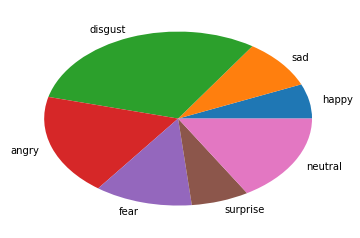

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(model.predict(targets)[0]*100.0, labels=emolabels)
print(examples[0])

今日は楽しい一日だったよ


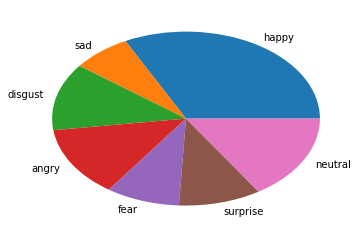

In [24]:
plt.pie(model.predict(targets)[1]*100.0, labels=emolabels)
print(examples[1])

ペットが死んだ、実に悲しい


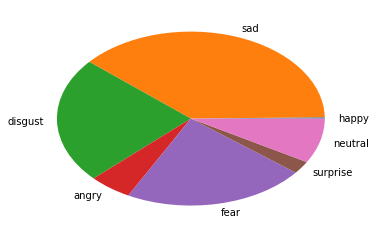

In [25]:
plt.pie(model.predict(targets)[2]*100.0, labels=emolabels)
print(examples[2])

ふざけるな、死ね


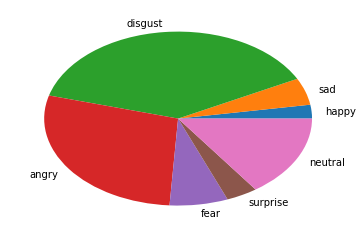

In [26]:
plt.pie(model.predict(targets)[3]*100.0, labels=emolabels)
print(examples[3])

ストーカー怖い


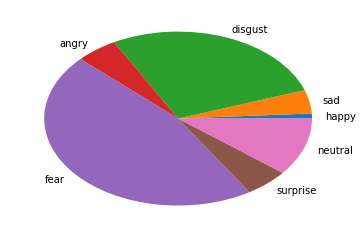

In [27]:
plt.pie(model.predict(targets)[4]*100.0, labels=emolabels)
print(examples[4])

すごい！ほんとに！？


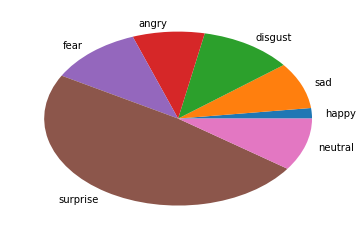

In [28]:
plt.pie(model.predict(targets)[5]*100.0, labels=emolabels)
print(examples[5])

葉は植物の構成要素です。


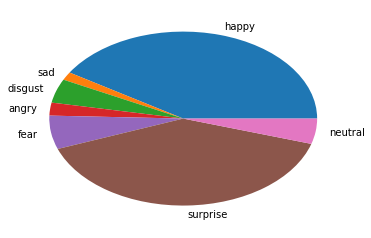

In [29]:
plt.pie(model.predict(targets)[6]*100.0, labels=emolabels)
print(examples[6])

ホームレスと囚人を集めて革命を起こしたい


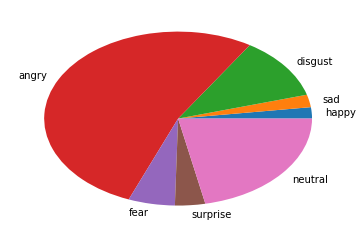

In [30]:
plt.pie(model.predict(targets)[7]*100.0, labels=emolabels)
print(examples[7])